In [2]:
%pip install opencv-python

  Using cached opencv_python-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (62.5 MB)

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# 코드 5-12 라이브러리 호출
import os
import time
import copy
import glob
import cv2  # 앞에서 설치한 OpenCV 라이브러리
import shutil

import torch
import torchvision  # 컴퓨터 비전(computer vision) 용도의 패키지
import torchvision.transforms as transforms  # 데이터 전처리를 위해 사용되는 패키지
import torchvision.models as models  # 다양한 파이토치 네트워크를 사용할 수 있도록 도와주는 패키지
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

/home/halozhan/딥러닝 파이토치 교과서/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# 코드 5-13 이미지 데이터 전처리 방법 정의

data_path = "../chap05/data/catanddog/train"  # 이미지 데이터가 위치한 경로 지정

transform = transforms.Compose(
    [
        transforms.Resize([256, 256]),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
train_dataset = torchvision.datasets.ImageFolder(data_path, transform=transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, num_workers=8, shuffle=True
)

print(len(train_dataset))

385


In [6]:
import numpy as np

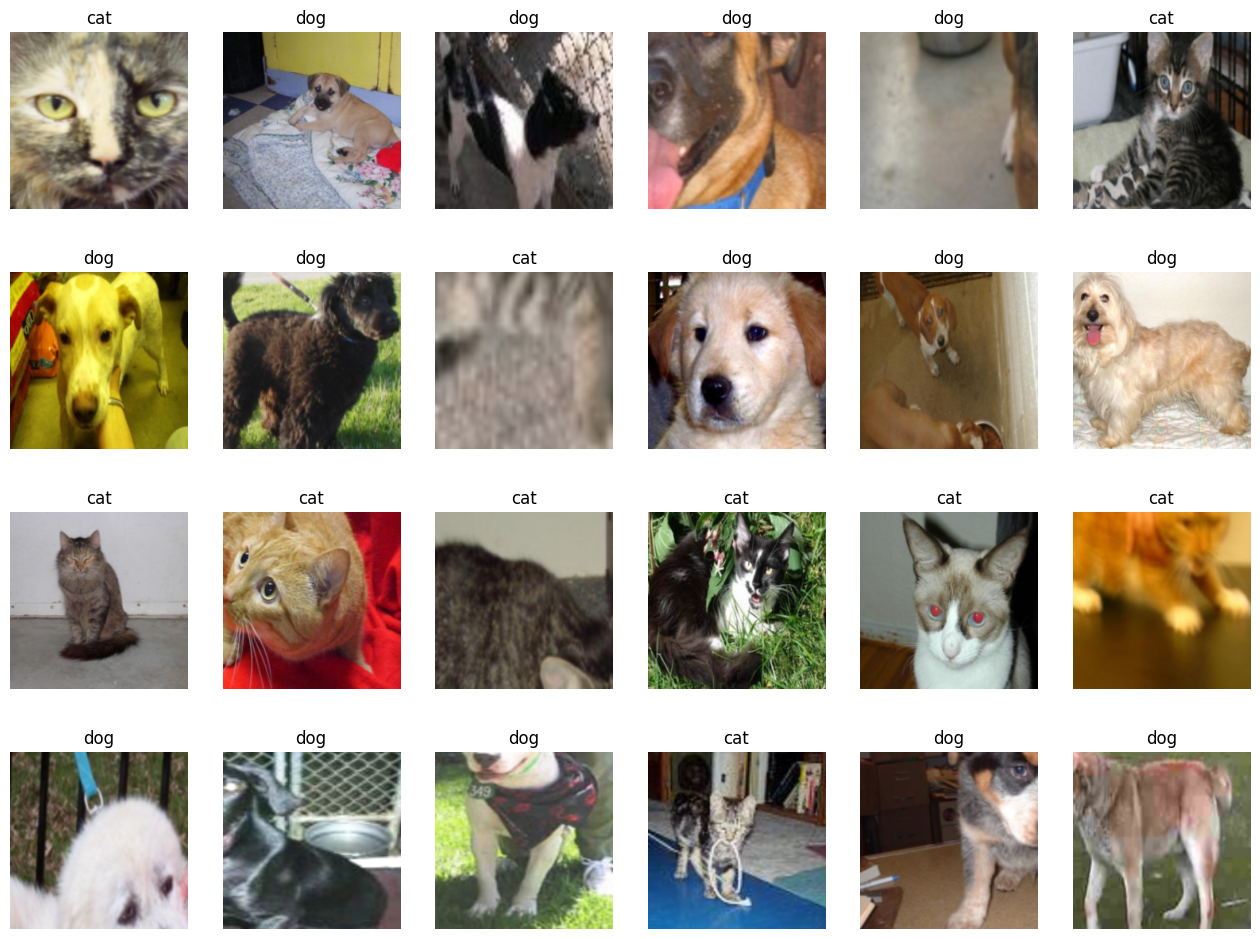

In [7]:
# 코드 5-14 학습에 사용될 이미지 출력

samples, labels = iter(train_loader).next()
classes = {0: "cat", 1: "dog"}  # 개와 고양이에 대한 클래스로 구성
fig = plt.figure(figsize=(16, 24))
for i in range(24):  # 24개의 이미지 데이터 출력
    a = fig.add_subplot(4, 6, i + 1)
    a.set_title(classes[labels[i].item()])  # 레이블 정보(클래스)를 함께 출력
    a.axis("off")
    a.imshow(np.transpose(samples[i].numpy(), (1, 2, 0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [8]:
# 코드 5-15 사전 훈련된 모델 내려받기
resnet18 = models.resnet18(
    pretrained=True
)  # pretrained=True는 사전 학습된 가중치를 사용하겠다는 의미

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/halozhan/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 57.3MB/s]


In [9]:
# 코드 5-16 사전 훈련된 모델의 파라미터 학습 유무 지정
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


set_parameter_requires_grad(resnet18)

In [10]:
# 코드 5-17 ResNet18에 완전연결층 추가
resnet18.fc = nn.Linear(512, 2)  # 2는 클래스가 두 개라는 의미

In [11]:
# 코드 5-18 모델의 파라미터 값 확인
for (
    name,
    param,
) in (
    resnet18.named_parameters()
):  # model.named_parameters()는 모델에 접근하여 파라미터 값들을 가져올 때 사용
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[ 0.0138,  0.0015,  0.0421,  ..., -0.0424,  0.0328,  0.0132],
        [ 0.0134,  0.0116,  0.0065,  ...,  0.0252,  0.0173, -0.0400]])
fc.bias tensor([ 0.0068, -0.0420])


In [12]:
# 코드 5-19 모델 객체 생성 및 손실 함수 정의
model = models.resnet18(pretrained=True)  # 모델의 객체 생성

for param in model.parameters():  # 모델의 합성곱층 가중치 고정
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters():  # 완전연결층은 학습
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()  # 손실 함수 정의
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
# 코드 5-20 모델 학습을 위한 함수 생성
def train_model(
    model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True
):
    since = time.time()  # 컴퓨터의 현재 시각을 구하는 함수
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs):  # 에포크(13)만큼 반복
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:  # 데이터로더에 전달된 데이터만큼 반복
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad()  # 기울기를 0으로 설정
            outputs = model(inputs)  # 순전파 학습
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()  # 역전파 학습
            optimizer.step()

            running_loss += loss.item() * inputs.size(
                0
            )  # 출력 결과와 레이블의 오차를 계산한 결과를 누적하여 저장
            running_corrects += torch.sum(
                preds == labels.data
            )  # 출력 결과와 레이블이 동일한지 확인한 결과를 누적하여 저장

        epoch_loss = running_loss / len(dataloaders.dataset)  # 평균 오차 계산
        epoch_acc = running_corrects.double() / len(
            dataloaders.dataset
        )  # 평균 정확도 계산

        print("Loss: {:.4f} Acc: {:.4f}".format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(
            model.state_dict(),
            os.path.join("../chap05/data/catanddog/", "{0:0=2d}.pth".format(epoch)),
        )  # 모델 재사용을 위해 저장해 둡니다.
        print()

    time_elapsed = time.time() - since  # 실행 시간(학습 시간)을 계산
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best Acc: {:4f}".format(best_acc))
    return acc_history, loss_history  # 모델의 정확도와 오차를 반환

In [14]:
# 코드 5-21 파라미터 학습 결과를 옵티마이저에 전달
params_to_update = []
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)  # 파라미터 학습 결과를 저장
        print("\t", name)

optimizer = optim.Adam(params_to_update)  # 학습 결과를 옵티마이저에 전달

	 fc.weight
	 fc.bias


In [15]:
# 코드 5-22 모델 학습
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()  # 손실 함수 지정
train_acc_hist, train_loss_hist = train_model(
    resnet18, train_loader, criterion, optimizer, device
)

Epoch 0/12
----------
Loss: 0.5817 Acc: 0.7117

Epoch 1/12
----------
Loss: 0.3782 Acc: 0.8416

Epoch 2/12
----------
Loss: 0.3526 Acc: 0.8597

Epoch 3/12
----------
Loss: 0.2908 Acc: 0.8961

Epoch 4/12
----------
Loss: 0.2420 Acc: 0.9065

Epoch 5/12
----------
Loss: 0.2476 Acc: 0.8987

Epoch 6/12
----------
Loss: 0.2783 Acc: 0.8727

Epoch 7/12
----------
Loss: 0.2088 Acc: 0.9273

Epoch 8/12
----------
Loss: 0.2088 Acc: 0.9377

Epoch 9/12
----------
Loss: 0.2684 Acc: 0.8805

Epoch 10/12
----------
Loss: 0.2054 Acc: 0.9351

Epoch 11/12
----------
Loss: 0.1806 Acc: 0.9299

Epoch 12/12
----------
Loss: 0.2169 Acc: 0.9039

Training complete in 0m 12s
Best Acc: 0.937662


In [16]:
# 코드 5-23 테스트 데이터 호출 및 전처리
test_path = "../chap05/data/catanddog/test"

transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)
test_dataset = torchvision.datasets.ImageFolder(root=test_path, transform=transform)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, num_workers=1, shuffle=True
)

print(len(test_dataset))

98


In [21]:
# 코드 5-24 테스트 데이터 평가 함수 생성
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob("../chap05/data/catanddog/" + "*.pth")
    saved_models.sort()  # 불러온 .pth 파일들을 정렬
    print("saved_model", saved_models)

    for model_path in saved_models:
        print("Loading model", model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:  # 테스트 반복
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():  # autograd를 사용하지 않겠다는 의미
                outputs = model(inputs)  # 데이터를 모델에 적용한 결과를 outputs에 저장

            _, preds = torch.max(outputs.data, 1)
            preds = preds.to(device)
            preds[preds >= 0.5] = (
                1  # torch.max로 출력된 값이 0.5보다 크면 올바르게 예측
            )
            preds[preds < 0.5] = 0  # torch.max로 출력된 값이 0.5보다 작으면 틀리게 예측
            running_corrects += preds.eq(labels).int().sum()

        epoch_acc = running_corrects.double() / len(
            dataloaders.dataset
        )  # 테스트 데이터의 정확도 계산
        print("Acc: {:.4f}".format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc
            acc_history.append(epoch_acc.item())
            print()

        time_elapsed = time.time() - since
        print(
            "Validation complete in {:.0f}m {:.0f}s".format(
                time_elapsed // 60, time_elapsed % 60
            )
        )
        print("Best Acc: {:4f}".format(best_acc))

        return acc_history  # 계산된 정확도 반환

In [22]:
# 코드 5-25 테스트 데이터를 평가 함수에 적용
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['../chap05/data/catanddog/00.pth', '../chap05/data/catanddog/01.pth', '../chap05/data/catanddog/02.pth', '../chap05/data/catanddog/03.pth', '../chap05/data/catanddog/04.pth', '../chap05/data/catanddog/05.pth', '../chap05/data/catanddog/06.pth', '../chap05/data/catanddog/07.pth', '../chap05/data/catanddog/08.pth', '../chap05/data/catanddog/09.pth', '../chap05/data/catanddog/10.pth', '../chap05/data/catanddog/11.pth', '../chap05/data/catanddog/12.pth']
Loading model ../chap05/data/catanddog/00.pth
Acc: 0.8878

Validation complete in 0m 0s
Best Acc: 0.887755


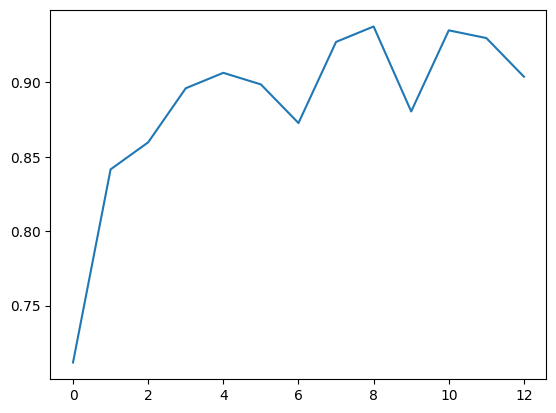

In [23]:
# 코드 5-26 훈련과 테스트 데이터의 정확도를 그래프로 확인
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

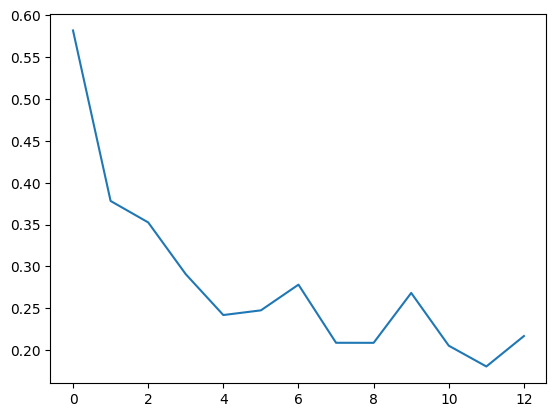

In [24]:
# 코드 5-27 훈련 데이터의 오차에 대한 그래프 확인
plt.plot(train_loss_hist)
plt.show()

In [25]:
# 코드 5-28 예측 이미지 출력을 위한 전처리 함수
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * (np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)))
    image = image.clip(0, 1)
    return image

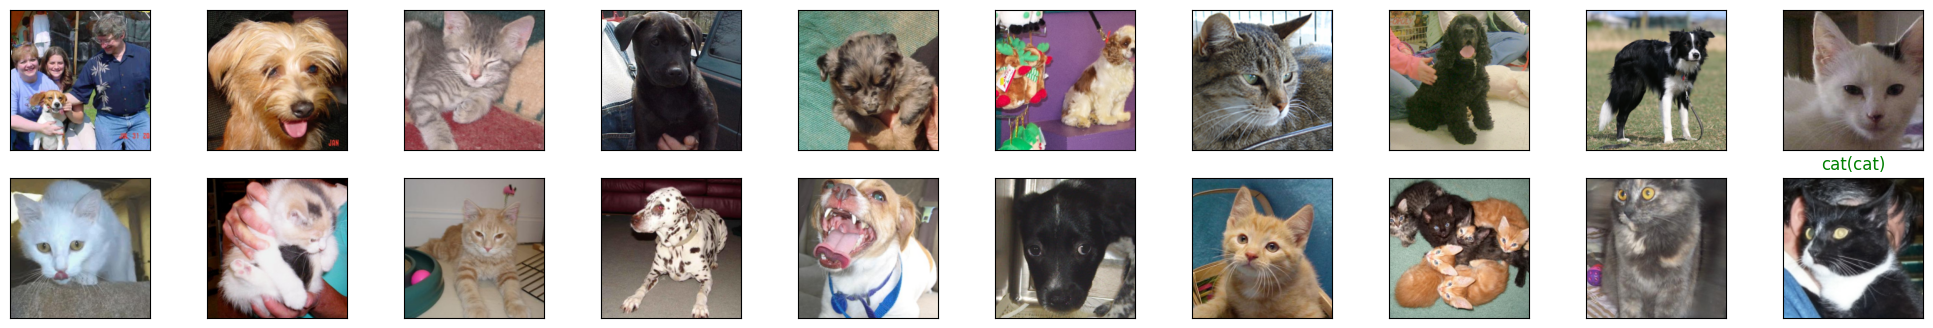

<Figure size 640x480 with 0 Axes>

In [26]:
# 코드 5-29 개와 고양이 예측 결과 출력
classes = {0: "cat", 1: "dog"}  # 개와 고양이 두 개에 대한 레이블

dataiter = iter(test_loader)  # 테스트 데이터셋을 가져옵니다.
images, labels = (
    dataiter.next()
)  # 테스트 데이터셋에서 이미지와 레이블을 분리하여 가져옵니다.
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    plt.imshow(
        im_convert(images[idx])
    )  # 이미지 출력을 위해 코드 5-28에서 정의한 im_convert 함수를 적용
    a.set_title(classes[labels[i].item()])
ax.set_title(
    "{}({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])),
    color=("green" if preds[idx] == labels[idx] else "red"),
)
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)